In [1]:
import os
import sys
import numpy as np
# import psycopg2
import sqlalchemy
from tqdm.notebook import tqdm
tqdm.pandas()
import pandas as pd
from collections import defaultdict
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(
    context='paper',
    font_scale=8/8.8,
#     context="talk",
    style='ticks',
    color_codes=True,
    rc={'legend.frameon': False})

plt.rcParams['svg.fonttype'] = 'none'

%matplotlib inline

In [2]:
import datashader as ds
from datashader.mpl_ext import dsshow
import datashader.transfer_functions as dstf

In [3]:
print(np.__version__)
print(pd.__version__)

1.22.1
1.3.5


In [4]:
import nfp
print(nfp.__version__)

2022-05-19 23:26:34.452881: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /nopt/slurm/current/lib:
2022-05-19 23:26:34.452916: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


0.3.6


In [5]:
os.chdir('../')

In [6]:
print(os.getcwd())
sys.path.append('../../')
import rlmolecule
from rlmolecule.sql.run_config import RunConfig
from rlmolecule.sql import Base, Session
from rlmolecule.sql.tables import GameStore, RewardStore, StateStore
from rlmolecule.crystal.crystal_state import CrystalState

/home/jlaw/projects/arpa-e/crystals/rlmolecule/examples/crystal_energy


In [7]:
# connect to the db
config_file = "config/config_experiments.yaml"
run_config = RunConfig(config_file)
engine = run_config.start_engine()
Session.configure(bind=engine)
session = Session()

38 actions_to_ignore


In [8]:
def load_games_played(session, run_id):
#     print("Loading games")
    df = pd.read_sql(session.query(GameStore).filter_by(run_id=run_id).statement, session.bind)

    df['time_hours'] = (df.time - df.time.min()).apply(lambda x: x.total_seconds() / 3600)
    df = df.sort_values('time_hours')
    df_games = df
    df_games.reset_index(drop=True, inplace=True)
#     print(df_games.tail(3))
    return df_games


def load_rewards(session, run_id):
#     print("Loading rewards")
    df = pd.read_sql(session.query(RewardStore).filter_by(run_id=run_id).statement, session.bind)
    # df['time_hours'] = (df.time - df.time.min()).apply(lambda x: x.total_seconds() / 3600)
    df = df.sort_values('reward', ascending=False)
    df_rew = df
#     print(df_rew.tail(3))
    return df_rew


def load_states(session, run_id):
#     print("Loading rewards")
    df = pd.read_sql(session.query(StateStore).filter_by(run_id=run_id).statement, session.bind)
    return df

def get_state_for_rew(digest, df_state):
    return df_state[df_state['digest'] == digest]


# def write_best_crystals():
#     df_rew = load_rewards

In [9]:
def plot_reward(df, log, out_dir, title=""):
    fig, ax = plt.subplots(figsize=(3, 2.75), dpi=150)
    axs = [ax]
    axs[0].plot(df.time_hours, df.raw_reward, '.', ms=.75, label='games')
    axs[0].plot(df.time_hours, df.raw_reward.rolling(250, min_periods=50).quantile(.75), label='$r_{75}$')

    axs[0].legend(loc='upper right', ncol=2, borderpad=0, borderaxespad=0,
                bbox_to_anchor=(1.1, 1.2), markerscale=10)

    axs[0].set_yticks(np.arange(-5, 5, 2))
    axs[0].set_ylabel('Reward')

    plt.tight_layout()
    sns.despine(offset=5, trim=True)
    plt.title(title)

    out_file = f"{out_dir}/training.svg"
    print(out_file)
    os.makedirs(os.path.dirname(out_file), exist_ok=True)
    plt.savefig(out_file, bbox_inches="tight")
    plt.savefig(out_file.replace('.svg','.pdf'), bbox_inches="tight")
    plt.savefig(out_file.replace('.svg','.png'), bbox_inches="tight")
    plt.show()
    plt.close()

In [23]:
def plot_reward_train_curves(df, log, out_dir, title=""):
    fig, axs = plt.subplots(sharex=True, nrows=2, figsize=(3, 2.75), dpi=150)
    axs[0].plot(df.time_hours, df.raw_reward, '.', ms=.75, alpha=.4, label='rollouts')
    # dsshow(df, ds.Point('time_hours', 'raw_reward'),
    #        ax=axs[0], shade_hook=dstf.dynspread, 
    #        cmap='Blues', norm='eq_hist', aspect='auto', 
    #        # y_range=yrange, x_range=xrange)
    #       )

    axs[0].plot(df.time_hours, df.raw_reward.rolling(250, min_periods=50).quantile(.75), label='$r_{75}$')

    axs[1].plot(log.time_hours, log.policy_wrapper_loss, label='value loss')
    axs[1].plot(log.time_hours, log.policy_wrapper_1_loss, label='prior loss')

    axs[0].legend(loc='upper right', ncol=2, borderpad=0, borderaxespad=0,
                bbox_to_anchor=(1.1, 1.2), markerscale=10)
    for lh in axs[0].get_legend().legendHandles:
        lh.set_alpha(1)
    axs[1].legend(
        loc='upper right', ncol=2,
        borderpad=0, borderaxespad=0.1,
        bbox_to_anchor=(1.1, 1.2))

    #axs[1].set_ylim([0, .7])
    #axs[1].set_xlim([-.01, 4])
    # axs[0].set_yticks(np.arange(-5, 1.1, 2))
    # axs[0].set_ylim(-3.1, 5.6)
    axs[1].set_yticks(np.arange(0, .7, .2))
    axs[1].set_ylim(0, .62)
    axs[0].set_ylabel('Reward')
    axs[1].set_ylabel('Policy Training')
    axs[1].set_xlabel('Time (hours)')

    plt.tight_layout()
    sns.despine(offset=5, trim=True)
    plt.suptitle(title, y=1.0)
    
    # plt.setp(axs[0].legend, alpha=1)

    out_file = f"{out_dir}/training-and-reward.svg"
    print(out_file)
    os.makedirs(os.path.dirname(out_file), exist_ok=True)
#     plt.savefig(out_file, bbox_inches="tight")
#     plt.savefig(out_file.replace('.svg','.pdf'), bbox_inches="tight")
    plt.savefig(out_file.replace('.svg','.png'), bbox_inches="tight")
    plt.show()
    plt.close()

# Compare Experiment Results

In [11]:
exp_name = "crystal_energy"
run_id = run_config.run_id
print(run_id)

crystal_energy_example


In [12]:
log_dir = f"/projects/rlmolecule/jlaw/logs/{exp_name}"
def main_results(run_id, session, limit_to_log=False):
    working_dir = f"{log_dir}/{run_id}"
    # load the games played
    df_games = load_games_played(session, run_id)
    df_games = df_games.dropna()
#     print(df_games.head(2))
#     print(len(df_games))

    log_file = f"{working_dir}/policy_checkpoints/log.csv"
    print(f"Reading {log_file}")
    log = pd.read_csv(log_file)
    log['time'] = pd.to_datetime(log.time)
    if limit_to_log:
        df_games = df_games[df_games.time >= log.time.min()]
        df_games['time_hours'] = (df_games.time - df_games.time.min()).apply(lambda x: x.total_seconds() / 3600)
    print(df_games.time.min())
    log['time_hours'] = (log.time - df_games.time.min()).apply(lambda x: x.total_seconds() / 3600)
#     print(log.tail(3))

        # df_games = df_games[df_games.time_hours >= log.time_hours]

    # now plot the results
    out_dir = f"{working_dir}/viz"
#     plot_reward(df_games, log, out_dir, title=run_id)
#     plot_reward_train_curves(df_games, log, out_dir, title=run_id)
    plot_reward_train_curves(df_games, log, out_dir)

    # and write POSCAR files for the best molecules
    df_rew = load_rewards(session, run_id)
#     print(df_rew.head(2))
    return df_games, df_rew

Reading /projects/rlmolecule/jlaw/logs/crystal_energy/20220504-batt-icsd-volpred-KLiNa-no-halides_test2/policy_checkpoints/log.csv
2022-05-19 15:22:25.427638
/projects/rlmolecule/jlaw/logs/crystal_energy/20220504-batt-icsd-volpred-KLiNa-no-halides_test2/viz/training-and-reward.svg


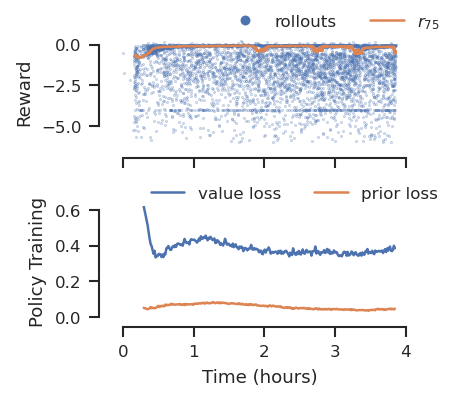

In [24]:
run_id = "20220504-batt-icsd-volpred-KLiNa-no-halides_test2"
df_games, df_rew = main_results(run_id, session)

Reading /projects/rlmolecule/jlaw/logs/crystal_energy/20220504-batt-icsd-volpred-KLiNa-no-ScY_test/policy_checkpoints/log.csv
2022-05-19 15:38:14.632530
/projects/rlmolecule/jlaw/logs/crystal_energy/20220504-batt-icsd-volpred-KLiNa-no-ScY_test/viz/training-and-reward.svg


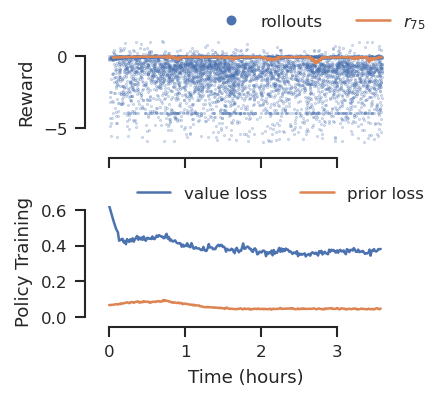

In [25]:
run_id = "20220504-batt-icsd-volpred-KLiNa-no-ScY_test"
df_games, df_rew = main_results(run_id, session, limit_to_log=True)

Reading /projects/rlmolecule/jlaw/logs/crystal_energy/20220504-batt-volpred-KLiNa/policy_checkpoints/log.csv
/projects/rlmolecule/jlaw/logs/crystal_energy/20220504-batt-volpred-KLiNa/viz/training-and-reward.svg


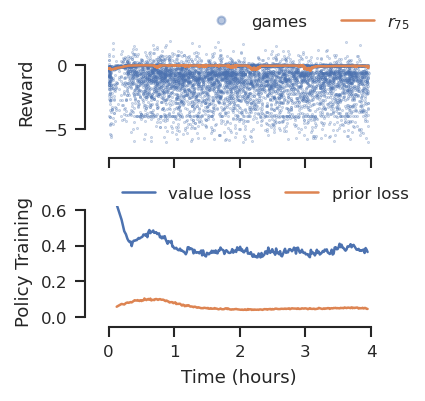

In [62]:
run_id = "20220504-batt-volpred-KLiNa"
df_games, df_rew = main_results(run_id, session)

In [49]:
import gzip, json
from pymatgen.core import Structure
def read_structures_file(structures_file):
    print(f"reading {structures_file}")
    with gzip.open(structures_file, 'r') as f:
        structures_dict = json.loads(f.read().decode())
    structures = {}
    for key, structure_dict in structures_dict.items():
        structures[key] = Structure.from_dict(structure_dict)
    print(f"\t{len(structures)} structures read")
    return structures

In [55]:
# load the icsd prototype structures
# https://pymatgen.org/usage.html#side-note-as-dict-from-dict
icsd_prototypes_file = "../../rlmolecule/crystal/inputs/icsd_prototypes_lt50atoms_lt100dist.json.gz"
proto_structures = read_structures_file(icsd_prototypes_file)

reading ../../rlmolecule/crystal/inputs/icsd_prototypes_lt50atoms_lt100dist.json.gz
	3304 structures read


In [51]:
vol_pred_site_bias_file = "/projects/rlmolecule/pstjohn/crystal_inputs/site_volumes_from_icsd.csv"
print(f"Reading {vol_pred_site_bias_file}")
site_bias = pd.read_csv(vol_pred_site_bias_file,
                        index_col=0, squeeze=True)
print(f"\t{len(site_bias)} elements")

Reading /projects/rlmolecule/pstjohn/crystal_inputs/site_volumes_from_icsd.csv
	60 elements


In [52]:
def scale_by_pred_vol(structure, vol_pred_site_bias, dls_vol_predictor):
    # first predict the volume using the average volume per element (from ICSD)
    site_counts = pd.Series(Counter(
        str(site.specie) for site in structure.sites)).fillna(0)
    curr_site_bias = vol_pred_site_bias[
        vol_pred_site_bias.index.isin(site_counts.index)]
    linear_pred = site_counts @ curr_site_bias
    structure.scale_lattice(linear_pred)

    # then apply Pymatgen's DLS predictor
    pred_volume = dls_vol_predictor.predict(structure)
    structure.scale_lattice(pred_volume)
    return structure

from pymatgen.analysis.structure_prediction.volume_predictor import DLSVolumePredictor
dls_vol_predictor = DLSVolumePredictor()

In [53]:
# TODO combine with decorate_structure()
def write_decorated_structure(decorated_str, out_dir):
    # print(f"writing {out_file}")
    decorated_structure.to(filename=out_file)
    
    # also write the original poscar file for reference
    out_file2 = f"{out_dir}/icsd_structures/{decorated_str.split('|')[-2]}"
    os.makedirs(os.path.dirname(out_file2), exist_ok=True)
    if not os.path.isfile(out_file2):
        icsd_prototype.to(filename=out_file2)
        
    return out_str

In [39]:
stats = {}
df_all = pd.DataFrame()
rew_cutoff = 0
for run_id in [
    # "20220509-rel-energy-cos-dist0.1-eles3-Li",
    # "20220504-batt-icsd-volpred-KLiNa",
    # "20220504-batt-volpred-KLiNa",
    "20220504-batt-icsd-volpred-KLiNa-no-halides_test2",
    "20220504-batt-icsd-volpred-KLiNa-no-ScY_test"
    ]:
    df_rew = load_rewards(session, run_id)
    # df_games, df_rew = main_results(run_id, session)
    top_rew = df_rew[df_rew['reward'] > rew_cutoff]
    best_crystal_states = {}
    for rew, data in top_rew[['reward', 'data']].values:
        best_crystal_states[data['state_repr']] = (
            rew, data['decomp_energy'], 
            data['predicted_energy'])
    best_crys_comp = [s.split('|')[0] for s in best_crystal_states]
    S = pd.Series(list(best_crys_comp))
    comp_counts = S.value_counts()

    # print(len(top_rew))
    # print(len(best_crystal_states))
    print(df_rew[df_rew['reward'] > rew_cutoff]['data'].apply(lambda x: x['state_repr']).nunique())
    print(f"# compositions: {len(comp_counts)}")
    stats[run_id] = (len(best_crystal_states), len(comp_counts))
    if len(comp_counts) == 0:
        continue
    
    # now write each of these to a file
    # UPDATE: just write the best decoration per composition
    df = pd.DataFrame(best_crystal_states).T.reset_index()
    df.columns = ['decor_id', 'reward', 'pred_decomp_energy', 'pred_energyperatom']
    df['comp'] = df.decor_id.apply(lambda x: x.split('|')[0])
    # df = df.loc[df.groupby('comp')['reward'].idxmax()]
    # out_dir = f"outputs/{run_id}/best_decorations"
    out_dir = f"{log_dir}/{run_id}/best_decorations"
    print(f"writing decoration energies to {out_dir}.csv")
    os.makedirs(out_dir, exist_ok=True)
    # out_strs = {}
    # for decorated_str, data in tqdm(best_crystal_states.items()):
        # out_str = write_decorated_structure(decorated_str, out_dir, proto_structures)
        # out_strs[out_str] = data
    # df_out = pd.DataFrame(out_strs).T
    # df_out.to_csv(f"{out_dir}/../best_decorations.csv", index_label='id',
    #               header=['reward', 'pred_decomp_energy', 'pred_energyperatom'])
    # df = df.reset_index()
    # wait to write the decorations to avoid duplicate structures
    # df['id'] = df.decor_id.progress_apply(write_decorated_structure, 
    #                                       out_dir=out_dir, 
    #                                       icsd_structures=proto_structures,
    #                                       vol_pred_site_bias=site_bias,
    #                                      )
    df.to_csv(f"{out_dir}/../best_decorations.csv")
    df_all = pd.concat([df_all, df])
df_all.reset_index(drop=True, inplace=True)

332
# compositions: 176
writing decoration energies to /projects/rlmolecule/jlaw/logs/crystal_energy/20220504-batt-icsd-volpred-KLiNa-no-halides_test2/best_decorations.csv
2160
# compositions: 272
writing decoration energies to /projects/rlmolecule/jlaw/logs/crystal_energy/20220504-batt-icsd-volpred-KLiNa-no-ScY_test/best_decorations.csv


In [40]:
for key, (num_strcs, num_comp) in stats.items():
    print('\t'.join(map(str, [key, num_strcs, num_comp])))

20220504-batt-icsd-volpred-KLiNa-no-halides_test2	332	176
20220504-batt-icsd-volpred-KLiNa-no-ScY_test	2160	272


In [41]:
df_all.drop_duplicates('decor_id', inplace=True)
print(len(df_all))
print(df_all[df_all.reward > rew_cutoff].decor_id.nunique())
print(df_all[df_all.reward > rew_cutoff].comp.nunique())

2422
2422
400


In [42]:
df_all.head(2)

,decor_id,reward,pred_decomp_energy,pred_energyperatom,comp
0,Na3W1N3|_1_3_3|monoclinic|sg12_icsd_023252|1,0.251,-0.251,-5.717773,Na3W1N3
1,Li4Ge1O4|_1_4_4|orthorhombic|sg63_icsd_065177|1,0.235,-0.235,-5.567801,Li4Ge1O4


In [44]:
def decorate_structure(decorated_str, icsd_structures, vol_pred_site_bias=None):
    # Now create the decoration of this composition onto this prototype structure
    # the 'action_node' string has the following format at this point:
    # comp_type|prototype_structure|decoration_idx
    # we just need 'comp_type|prototype_structure' to get the icsd structure
    composition = decorated_str.split('|')[0]
    structure_key = '|'.join(decorated_str.split('|')[1:-1])
    icsd_prototype = icsd_structures[structure_key]
    decoration_idx = int(decorated_str.split('|')[-1]) - 1
    # print(decorated_str, composition, structure_key)
    try:
        decorated_structure, comp = CrystalState.decorate_prototype_structure(
            icsd_prototype, composition, decoration_idx=decoration_idx)
        # also predict the volume
        if vol_pred_site_bias is not None:
            decorated_structure = scale_by_pred_vol(decorated_structure, 
                                                    vol_pred_site_bias,
                                                    dls_vol_predictor,
                                                   )
        #decorations[descriptor] = decorated_structure.as_dict()
    except AssertionError as e:
        print(f"AssertionError: {e}")
        return
        #volume_stats[descriptor] = (-1, -1, 0, comp_type)
        #return 0.0, {'terminal': True, 'state_repr': repr(state)}
    
    return decorated_structure

In [45]:
def extract_id(decorated_str):
    decor_split = decorated_str.split('|')
    out_str = '_'.join([decor_split[0], decor_split[3].replace('POSCAR_',''), decor_split[4]])
    return out_str

In [46]:
def write_structure(row, out_dir):
    out_file = f"{out_dir}/best_decorations/POSCAR_{row.id}"
    row.structure.to(filename=out_file)

In [56]:
# out_dir = "/projects/rlmolecule/jlaw/crystal_outputs/2022-05-09-batt-icsd-cos-dist-Li"
out_dir = "/projects/rlmolecule/jlaw/crystal_outputs/2022-05-04/batt-icsd-volpred-KLiNa-no-halides-ScY"
# out_dir = "/projects/rlmolecule/jlaw/crystal_outputs/2022-05-04/volpred-KLiNa"
os.makedirs(out_dir, exist_ok=True)
df_all['id'] = df_all.decor_id.apply(extract_id)
df_all = df_all.loc[df_all.groupby('comp')['reward'].idxmax().values]
df_all['structure'] = df_all.decor_id.progress_apply(decorate_structure,
                                                     icsd_structures=proto_structures,
                                                     vol_pred_site_bias=site_bias,
                                                     )
# df_all['volume'] = df_all.structure.apply(lambda x: x.volume)
df_all['dls_volume'] = df_all.structure.apply(lambda x: x.volume)
df_all.to_pickle(f"{out_dir}/best_decorations.p")

os.makedirs(f"{out_dir}/best_decorations", exist_ok=True)
df_all.apply(write_structure, out_dir=out_dir, axis=1)
df_all.head(2)

  0%|          | 0/400 [00:00<?, ?it/s]

,decor_id,reward,pred_decomp_energy,pred_energyperatom,comp,id,structure,dls_volume
409,K1Al1Br4|_1_1_4|orthorhombic|sg33_icsd_404394|1,0.907,-0.907,-3.266222,K1Al1Br4,K1Al1Br4_sg33_icsd_404394_1,"[[7.33708713 8.58120866 1.77059988] Al, [5.957...",1154.463218
1820,K1Al1Cl4|_1_1_4|orthorhombic|sg21_icsd_079527|1,0.099,-0.099,-3.792170,K1Al1Cl4,K1Al1Cl4_sg21_icsd_079527_1,[[2.73436021e-16 2.73436021e-16 4.46554911e+00...,1509.532585


89    None
74    None
34    None
0     None
92    None
79    None
76    None
20    None
14    None
9     None
8     None
19    None
24    None
22    None
69    None
32    None
46    None
18    None
dtype: object

In [192]:
# write all structures to the same place
out_dir = "/projects/rlmolecule/jlaw/crystal_outputs/2022-04-27-batt-icsd-vol-combined/best_decorations"
os.makedirs(out_dir, exist_ok=True)
df_all = df_all.loc[df_all.groupby('comp')['reward'].idxmax().values]
print(len(df_all))
df_all['id'] = df_all.decor_id.progress_apply(write_decorated_structure, 
                                      out_dir=out_dir, 
                                      icsd_structures=proto_structures,
                                      vol_pred_site_bias=site_bias,
                                     )
df_all['proto_id'] = df_all['id'].apply(lambda x: 'icsd_' + x.split('_')[-2])
df_all.set_index('id').to_csv(f"{out_dir}/../best_decorations.csv")
df_all.head(2)

1279


  0%|          | 0/1279 [00:00<?, ?it/s]

,decor_id,reward,pred_decomp_energy,pred_energyperatom,comp,id,proto_id
47167,K1B1Cl4|_1_1_4|orthorhombic|POSCAR_sg31_icsd_0...,2.469,-2.469,-6.294676,K1B1Cl4,K1B1Cl4_sg31_icsd_065882_1,icsd_065882
47121,K1B1Ge1Cl5N1|_1_1_1_1_5|tetragonal|POSCAR_sg12...,2.921,-2.921,-7.483702,K1B1Ge1Cl5N1,K1B1Ge1Cl5N1_sg129_icsd_420040_2,icsd_420040


In [28]:
def test(x):
    return 1,2,3
df2 = df.head()
df2[['a', 'b', 'c']] = df2.apply(test, axis=1, result_type='expand')
df2

/lustre/eaglefs/projects/rlmolecule/jlaw/envs/crystals_nfp0_3/lib/python3.8/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,decor_id,reward,pred_decomp_energy,pred_energyperatom,comp,a,b,c
0,K1Ge2Cl6N1|_1_1_2_6|cubic|POSCAR_sg225_icsd_03...,3.799,-3.799,-7.755982,K1Ge2Cl6N1,1,2,3
1,K1B2Cl7|_1_2_7|cubic|POSCAR_sg205_icsd_024854|1,3.033,-3.033,-6.938518,K1B2Cl7,1,2,3
2,K1B2Cl7|_1_2_7|tetragonal|POSCAR_sg141_icsd_02...,3.003,-3.003,-6.908506,K1B2Cl7,1,2,3
3,K1Ge2Cl6N1|_1_1_2_6|orthorhombic|POSCAR_sg62_i...,2.921,-2.921,-6.877828,K1Ge2Cl6N1,1,2,3
4,K1B2Cl7|_1_2_7|hexagonal|POSCAR_sg173_icsd_075...,2.743,-2.743,-6.648516,K1B2Cl7,1,2,3


In [ ]:
df = pd.DataFrame(

In [192]:
# write structures to a 
out_dir = "/projects/rlmolecule/jlaw/crystal_outputs/2022-04-27-batt-icsd-vol-combined/best_decorations"
os.makedirs(out_dir, exist_ok=True)
df_all = df_all.loc[df_all.groupby('comp')['reward'].idxmax().values]
print(len(df_all))
df_all['id'] = df_all.decor_id.progress_apply(write_decorated_structure, 
                                      out_dir=out_dir, 
                                      icsd_structures=proto_structures,
                                      vol_pred_site_bias=site_bias,
                                     )
df_all['proto_id'] = df_all['id'].apply(lambda x: 'icsd_' + x.split('_')[-2])
df_all.set_index('id').to_csv(f"{out_dir}/../best_decorations.csv")
df_all.head(2)

1279


  0%|          | 0/1279 [00:00<?, ?it/s]

,decor_id,reward,pred_decomp_energy,pred_energyperatom,comp,id,proto_id
47167,K1B1Cl4|_1_1_4|orthorhombic|POSCAR_sg31_icsd_0...,2.469,-2.469,-6.294676,K1B1Cl4,K1B1Cl4_sg31_icsd_065882_1,icsd_065882
47121,K1B1Ge1Cl5N1|_1_1_1_1_5|tetragonal|POSCAR_sg12...,2.921,-2.921,-7.483702,K1B1Ge1Cl5N1,K1B1Ge1Cl5N1_sg129_icsd_420040_2,icsd_420040


In [147]:
df_all.proto_id.value_counts()

icsd_071581    74
icsd_066994    17
icsd_407646    13
icsd_202422    12
icsd_034944    12
               ..
icsd_419918     1
icsd_002763     1
icsd_246005     1
icsd_100477     1
icsd_409537     1
Name: proto_id, Length: 113, dtype: int64

### Compare what the predicted energy would have been for the GNN trained on volume-relaxed structures only

In [24]:
# plot the hull energy by the predicted energy
df_games.head(2)

,id,run_id,time,raw_reward,scaled_reward,search_statistics,execution_statistics,time_hours
0,11cf6b02-ee4f-489f-8318-4990c8cfbb85,20220422-batt-icsd-vol-norm-2,2022-04-23 07:48:45.882994,0.067,0.0,[[4f27ce5de30b5dbb727c1b2601211b1e7a7bc4b1ceb3...,"{'total_time': 8.640500783920288, 'execution_t...",0.000000
1,d09ba621-c763-4504-a393-1665f56a9669,20220422-batt-icsd-vol-norm-2,2022-04-23 07:48:45.893185,0.263,1.0,[[4f27ce5de30b5dbb727c1b2601211b1e7a7bc4b1ceb3...,"{'total_time': 8.583186388015747, 'execution_t...",0.000003


In [25]:
df_rew.head(2)

,digest,hash,run_id,time,reward,data
122061,36d22a812d52708cc535666c806a40237bc7f26f9f846f...,8394969624402074818,20220422-batt-icsd-vol-norm-2,2022-04-23 08:30:31.061436,5.555,"{'terminal': True, 'predicted_energy': -8.6870..."
292165,d484257b1d92e7b86f00472a2cb39297428d6e02e51d5f...,440404501447798281,20220422-batt-icsd-vol-norm-2,2022-04-23 09:22:40.840474,5.533,"{'terminal': True, 'predicted_energy': -8.5820..."


In [26]:
len(df_rew)

677439

In [177]:
# compare the decorations common for different runs
stats = {}
df_all = pd.DataFrame()
rew_cutoff = 2
for run_id in [
    # "20220422-batt-icsd-vol-2-Li",
    "20220422-batt-icsd-volpred-Li",
    "20220422-batt-icsd-volpred-Li-debug",
    ]:
    df_rew = load_rewards(session, run_id)
    print(f"{run_id}: {len(df_rew)} rewards")
    # df_games, df_rew = main_results(run_id, session)
    top_rew = df_rew[df_rew['reward'] > rew_cutoff]
    best_crystal_states = {}
    for rew, data in top_rew[['reward', 'data']].values:
        best_crystal_states[data['state_repr']] = (
            rew, data['hull_energy'], 
            data['predicted_energy'])
    best_crys_comp = [s.split('|')[0] for s in best_crystal_states]
    S = pd.Series(list(best_crys_comp))
    comp_counts = S.value_counts()

    num_decors = df_rew[df_rew['reward'] > rew_cutoff]['data'].apply(lambda x: x['state_repr']).nunique()
    print(f"{run_id}: {num_decors} decorations, {len(comp_counts)} compositions")
    stats[run_id] = (len(best_crystal_states), len(comp_counts))
    
    df = pd.DataFrame(best_crystal_states).T.reset_index()
    df.columns = ['decor_id', 'reward', 'pred_decomp_energy', 'pred_energyperatom']
    df['comp'] = df.decor_id.apply(lambda x: x.split('|')[0])
    df['run_id'] = run_id
    df_all = pd.concat([df_all, df])
df_all.reset_index(drop=True, inplace=True)
df_all.head(2)

20220422-batt-icsd-volpred-Li: 127576 rewards
20220422-batt-icsd-volpred-Li: 2892 decorations, 182 compositions
20220422-batt-icsd-volpred-Li-debug: 58348 rewards
20220422-batt-icsd-volpred-Li-debug: 1596 decorations, 118 compositions


,decor_id,reward,pred_decomp_energy,pred_energyperatom,comp,run_id
0,Li2Ge1F1Cl5|_1_1_2_5|hexagonal|POSCAR_sg194_ic...,3.945,-3.945,-7.688665,Li2Ge1F1Cl5,20220422-batt-icsd-volpred-Li
1,Li2Ge1F1Cl5|_1_1_2_5|hexagonal|POSCAR_sg194_ic...,3.883,-3.883,-7.627611,Li2Ge1F1Cl5,20220422-batt-icsd-volpred-Li


In [178]:
states1 = set(df_all[df_all.run_id == "20220422-batt-icsd-volpred-Li"].decor_id)
states2 = set(df_all[df_all.run_id == "20220422-batt-icsd-volpred-Li-debug"].decor_id)
print(len(states1 & states2))
states1 = set(df_all[df_all.run_id == "20220422-batt-icsd-volpred-Li"].comp)
states2 = set(df_all[df_all.run_id == "20220422-batt-icsd-volpred-Li-debug"].comp)
print(len(states1 & states2))

1204
89
